# Import Libraries

In [47]:
import pandas as pd
import numpy as np
from causalml.inference.meta import LRSRegressor, XGBTRegressor,BaseRRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from causalml.inference.meta import BaseXLearner, BaseSLearner, BaseTLearner, BaseRLearner
from causalml.inference.meta.explainer import Explainer
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.pipeline import Pipeline

# Import Data

In [48]:
df = pd.read_csv('/Users/qianlou/Documents/GitHub/Customer-Personality-Analysis-2.0/Data/Preprocessed Data/Final Preprocessed Data.csv')

# Causal Inference Pipeline

In [49]:
def causal_inference_pipeline(df, X_cols, treatments, outcome):
    # Convert boolean columns to integer
    bool_cols = [col for col in df if df[col].dtype == np.bool]
    for col in bool_cols:
        df[col] = df[col].astype(int)
        
    results = []

    for treatment in treatments:
        # Prepare covariates
        covariates = [col for col in X_cols if col != treatment and col != outcome]
        if outcome == 'Total_purchase':
            covariates.remove('Total_amount')
        elif outcome == 'Total_amount':
            covariates.remove('Total_purchase')
        X = df[covariates]
        y = df[outcome]
        t = df[treatment]

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
            X, y, t, test_size=0.2, random_state=42)

        lowest_rmse = float('inf')
        best_model = None
        best_ate = None
        best_shap_values = None

        # Iterate over model types
        for model_type in [XGBRegressor, XGBTRegressor]:
            try:
                # Model instantiation
                if model_type == XGBRegressor:
                    model = model_type()
                    model.fit(X_train, y_train)
                    xgb_model = XGBRegressor()
                    xgb_model.fit(X_train, y_train)
                    explainer = shap.Explainer(xgb_model)
                    shap_values = explainer(X_test)
                else:
                    model = model_type()
                    model.fit(X_train, t_train, y_train)

                # Estimate ATE
                ate_mean, ate_std = cross_validate_ate(model, X, t, y)

                # Predictions for MSE calculation
                y_pred = model.predict(X_test)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                if rmse < lowest_rmse:
                    lowest_rmse = rmse
                    best_model = model
                    best_ate = ate_mean
                    best_shap_values = shap_values

            except Exception as e:
                print(f"Error training model for treatment {treatment}:", e)

        if best_shap_values is not None:
            plt.title(f'SHAP Values for Treatment: {treatment} ({best_model.__class__.__name__})')
            shap.summary_plot(best_shap_values, X_test, plot_type="bar")
            plt.show()

            plt.title(f'SHAP Values for Treatment: {treatment} ({best_model.__class__.__name__})')
            shap.plots.beeswarm(best_shap_values, max_display=30)
            plt.show()

        results.append({
            'Treatment': treatment,
            'Model Type': best_model.__class__.__name__ if best_model else None,
            'ATE': best_ate,
            'RMSE': lowest_rmse
        })

    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
    else:
        results_df = pd.DataFrame()

    return results_df

def cross_validate_ate(estimator, X, treatment, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    ate_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        treatment_train, treatment_test = treatment.iloc[train_index], treatment.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        estimator.fit(X_train, treatment_train, y_train)
        ate_estimate = np.mean(estimator.predict(X_test))
        ate_scores.append(ate_estimate)

    return np.mean(ate_scores), np.std(ate_scores)

# Causal 1: Recency Impact

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
[17:30:11] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


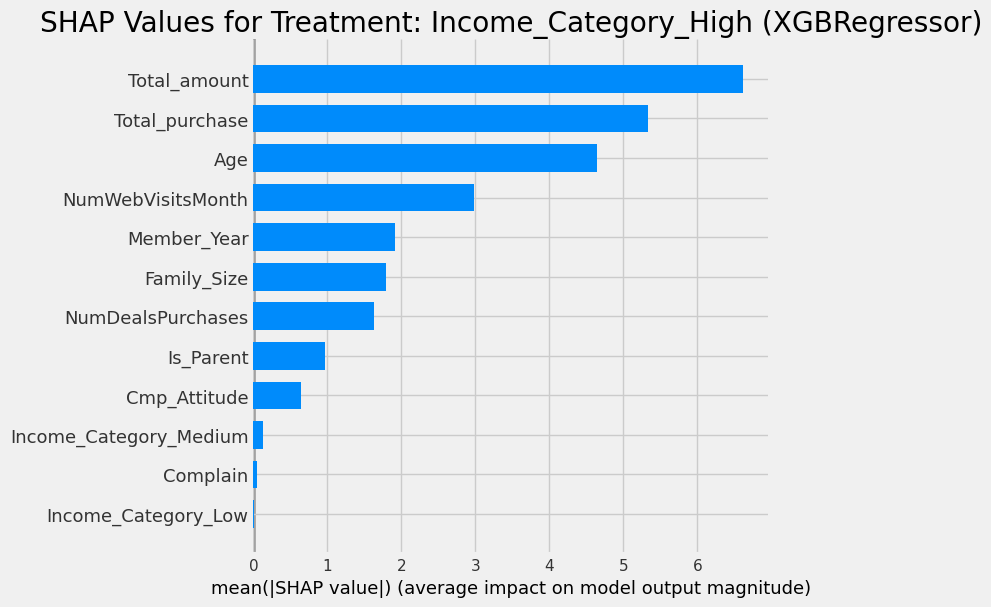

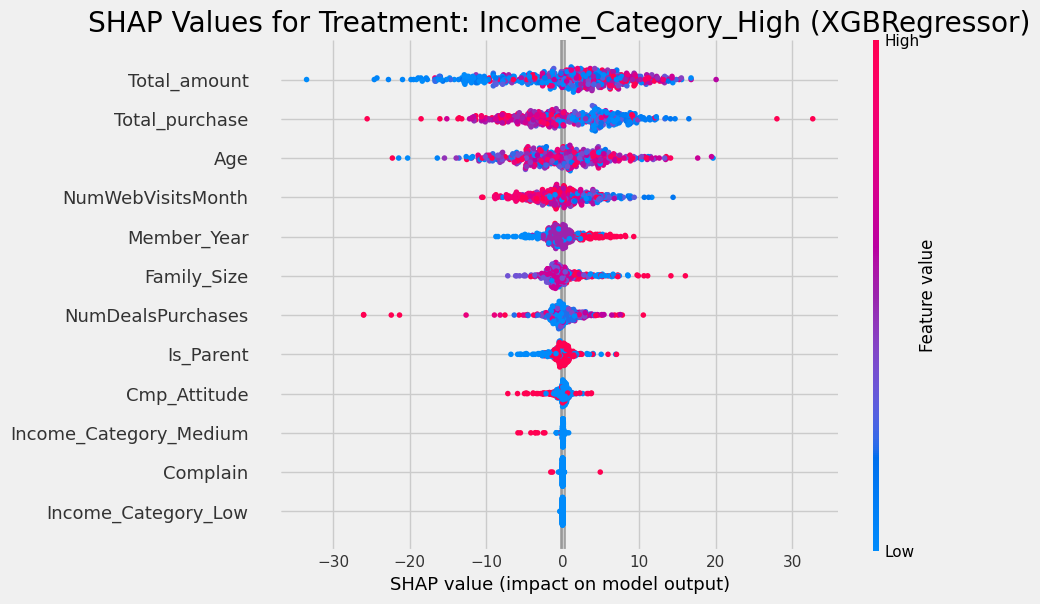

[17:30:13] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[17:30:14] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


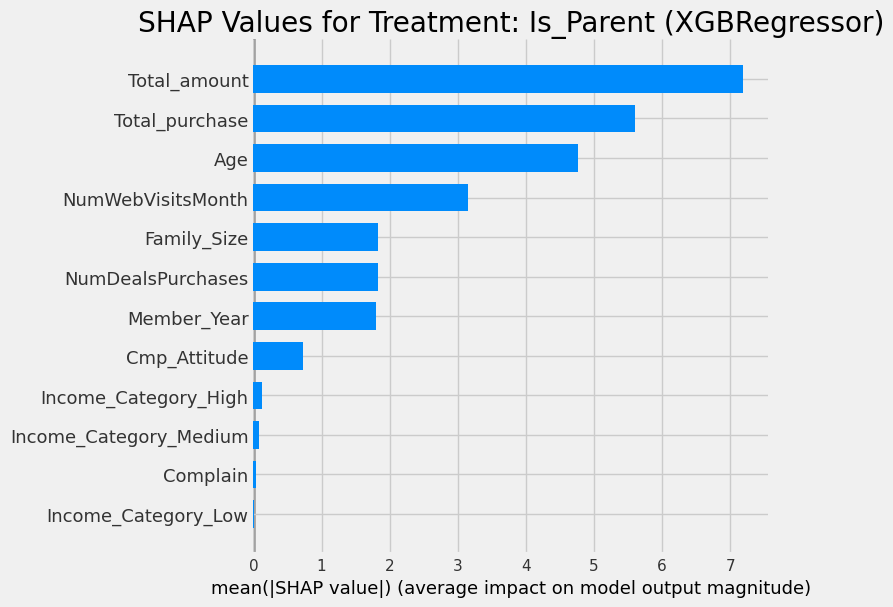

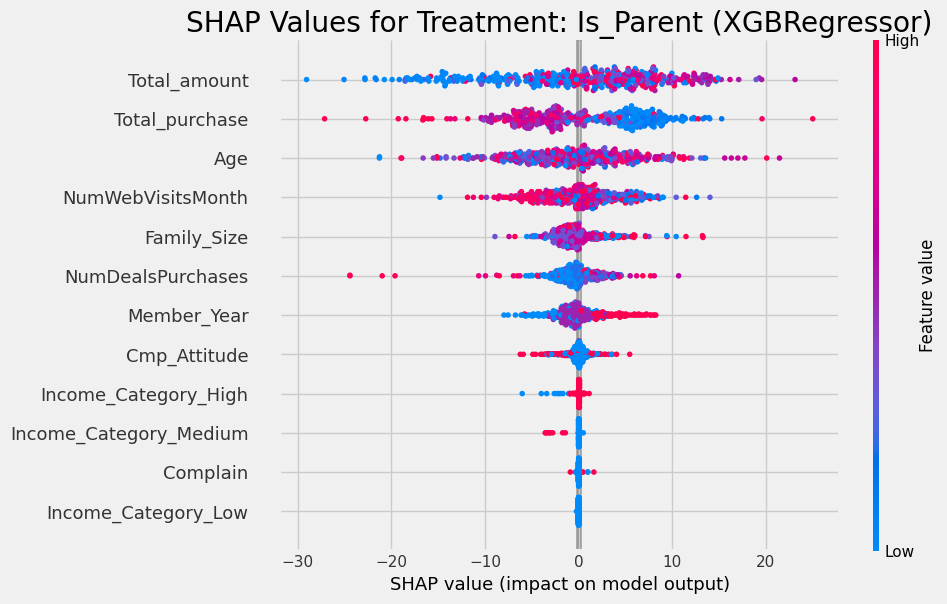

[17:30:16] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[17:30:17] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


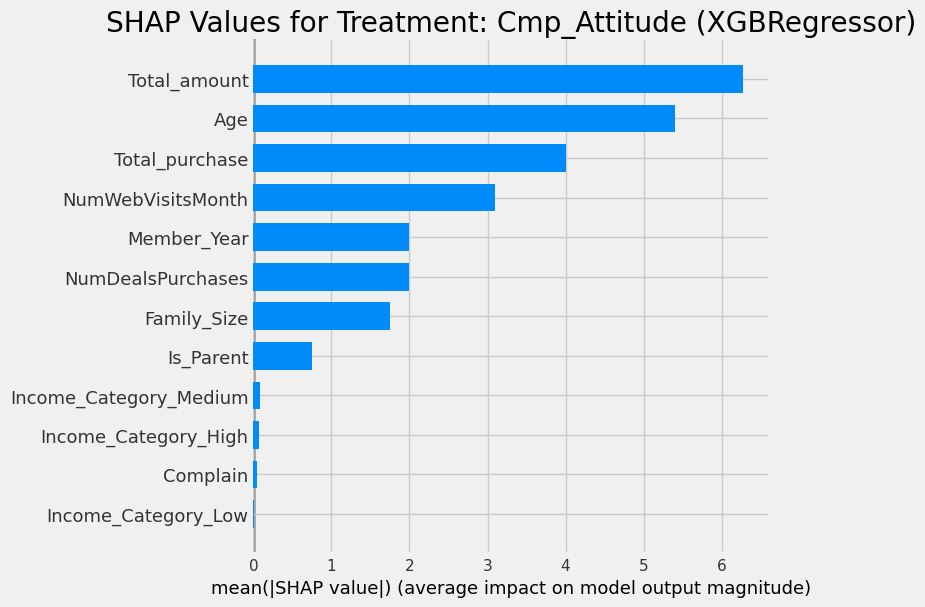

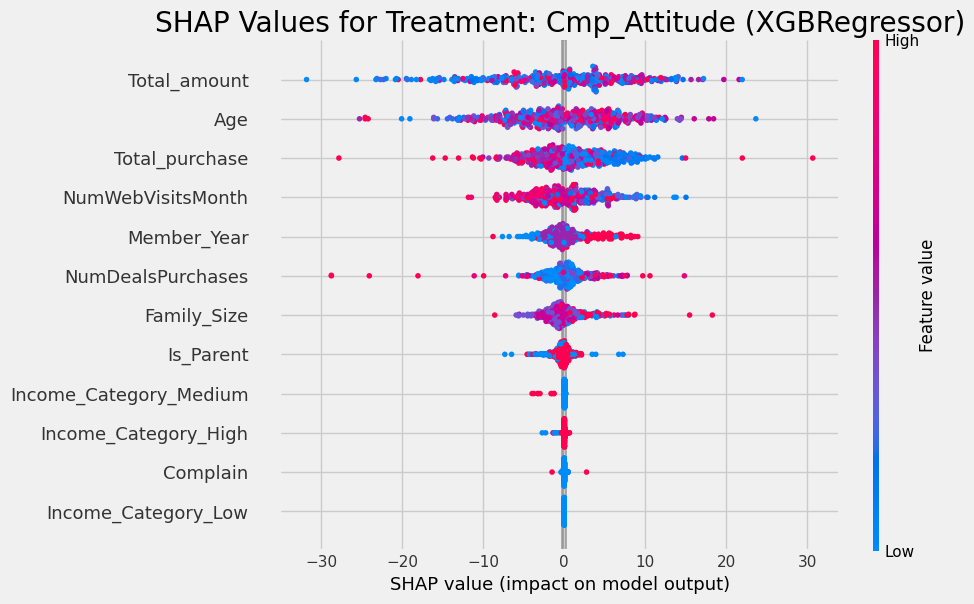

[17:30:20] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


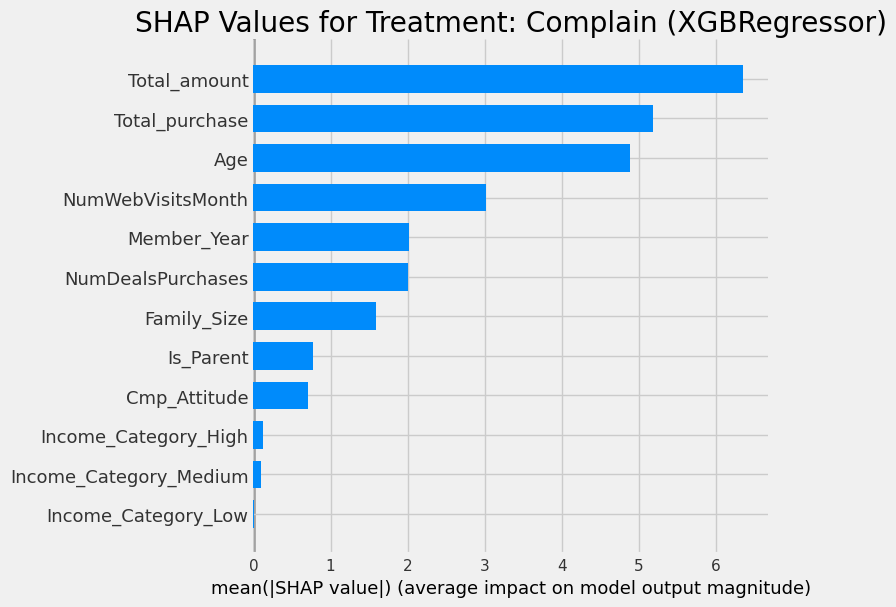

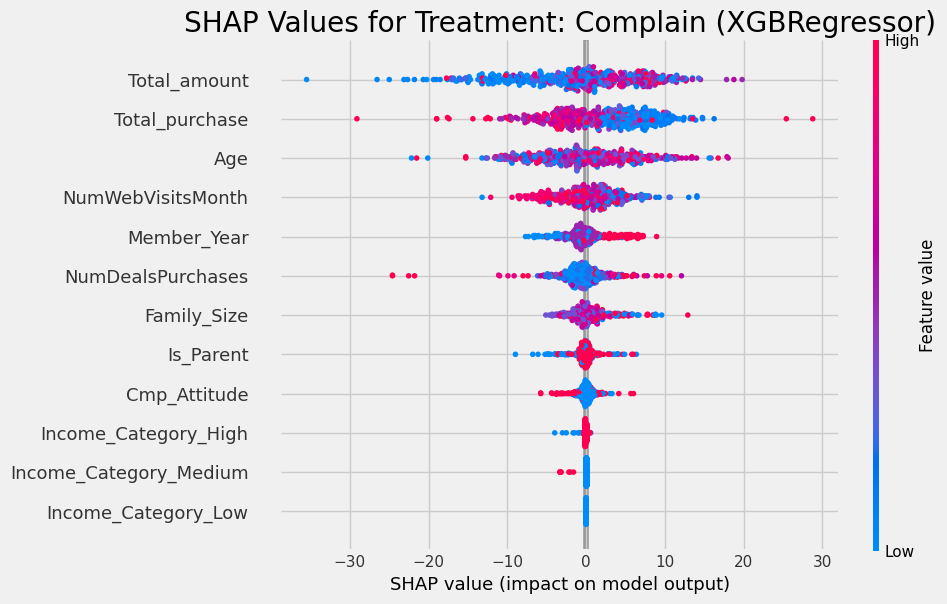

              Treatment    Model Type       ATE       RMSE
0  Income_Category_High  XGBRegressor  0.984333  54.668270
1             Is_Parent  XGBRegressor  0.714969  54.865256
2          Cmp_Attitude  XGBRegressor  0.217046  55.342698
3              Complain  XGBRegressor  0.012355  55.493829


In [50]:
treatments = ['Income_Category_High', 'Is_Parent', 'Cmp_Attitude', 'Complain']
covariates_list = ['Income_Category_High', 'Income_Category_Low', 'Income_Category_Medium',
    'Complain', 'Is_Parent', 'Cmp_Attitude', 'Family_Size', 'Age',
    'Member_Year', 'Total_amount', 'Total_purchase',
    'NumWebVisitsMonth', 'NumDealsPurchases', 'Recency']
outcome = 'Recency'

results_df = causal_inference_pipeline(df, covariates_list, treatments, outcome)
print(results_df)

# Causal 2: Frequency Impact

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
[17:30:22] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[17:30:23] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


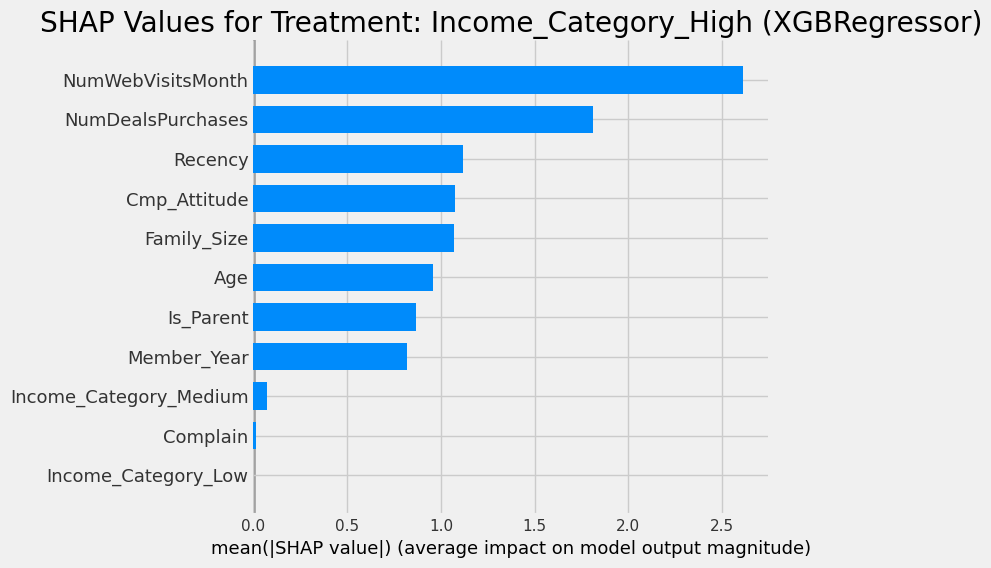

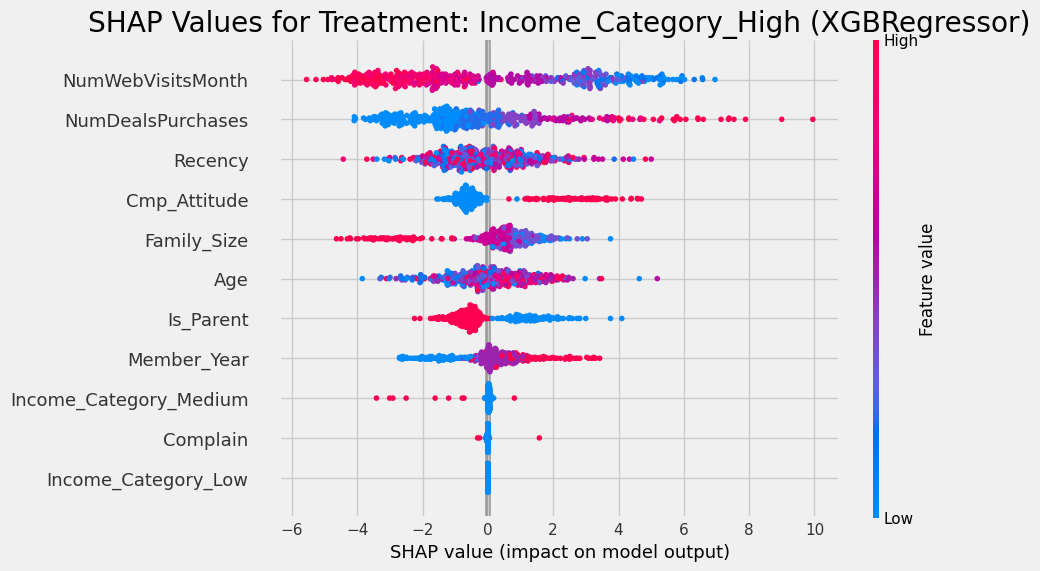

[17:30:25] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


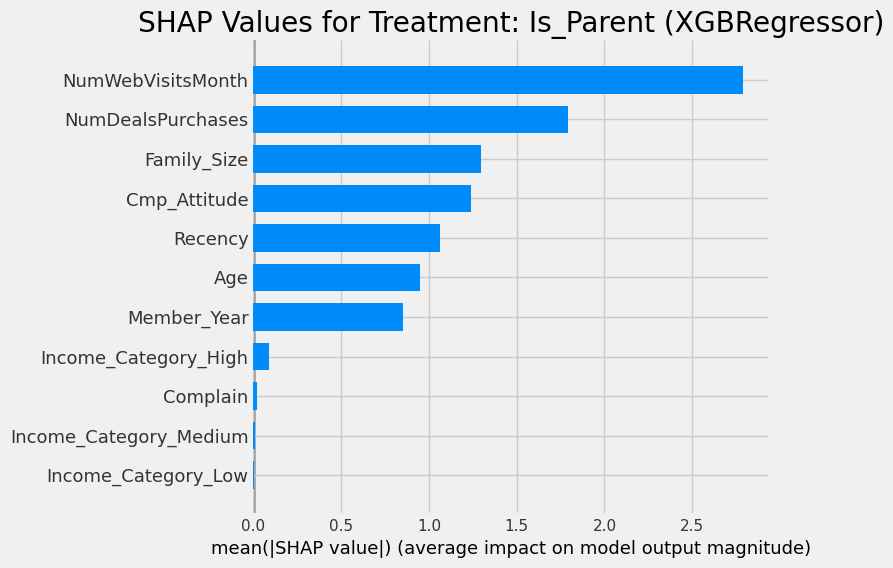

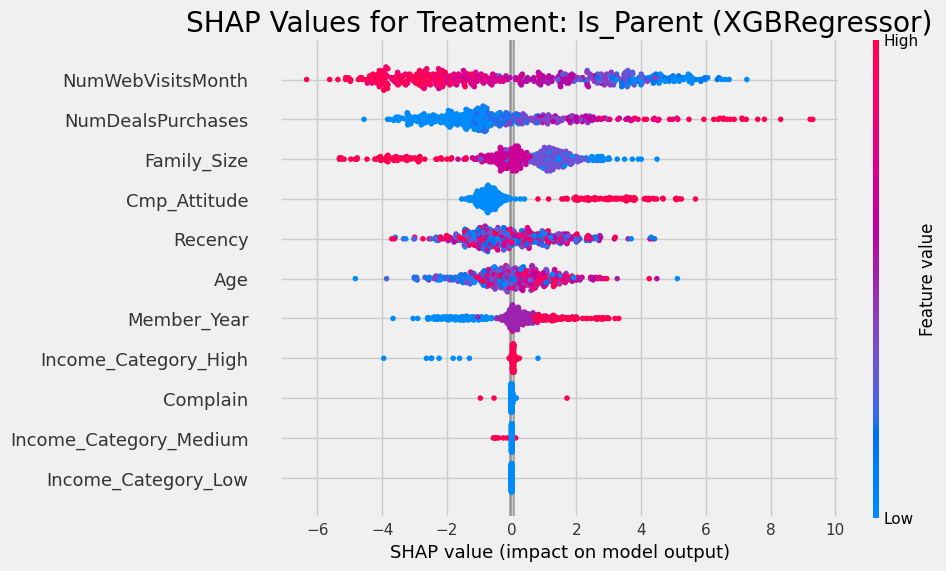

[17:30:28] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


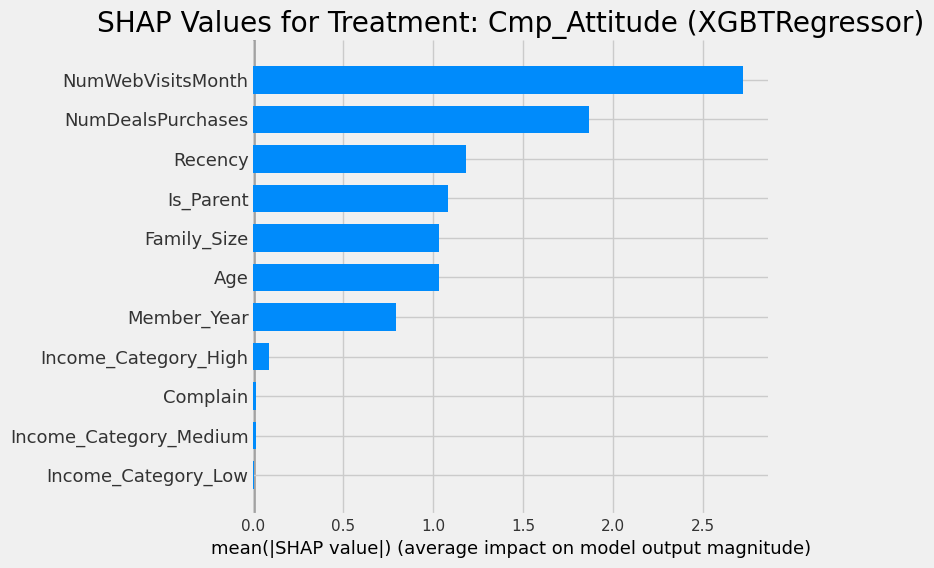

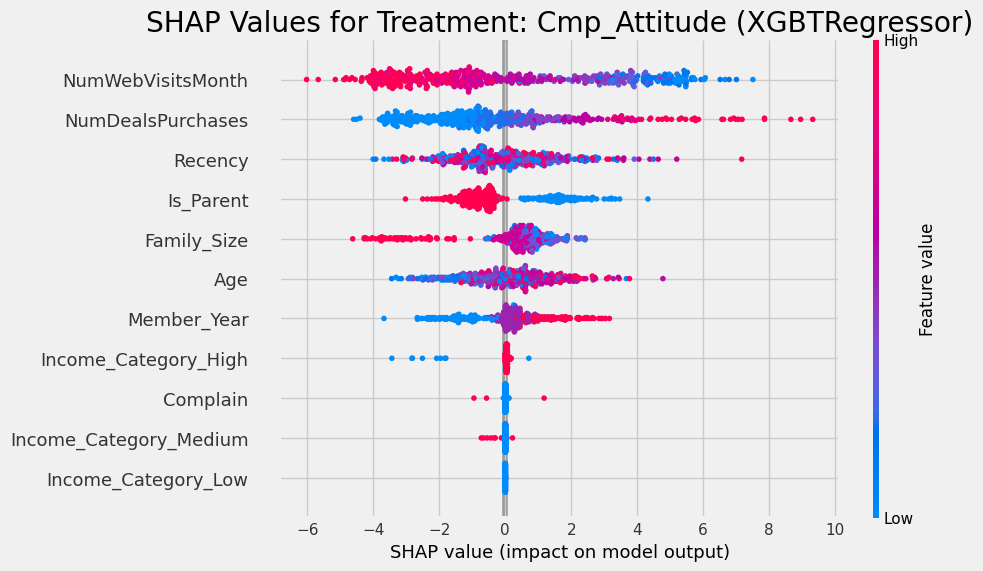

[17:30:31] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


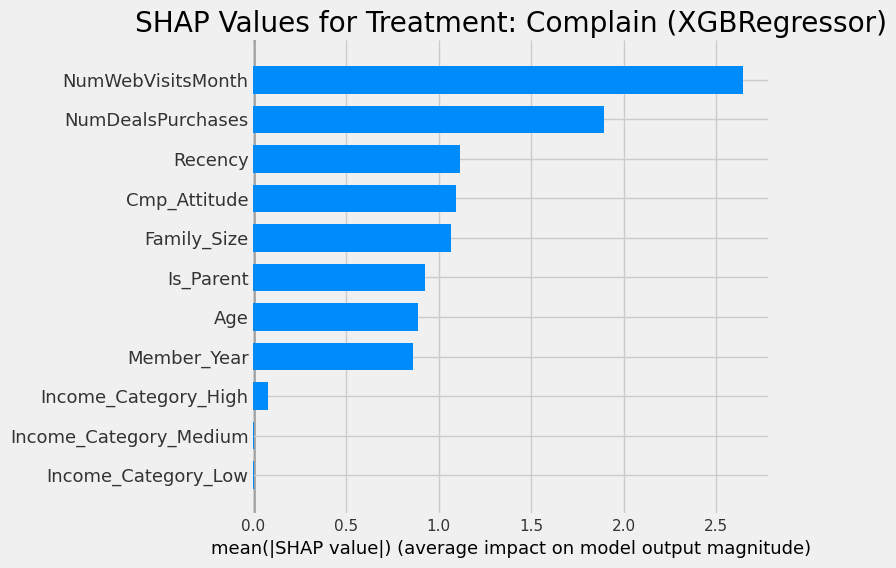

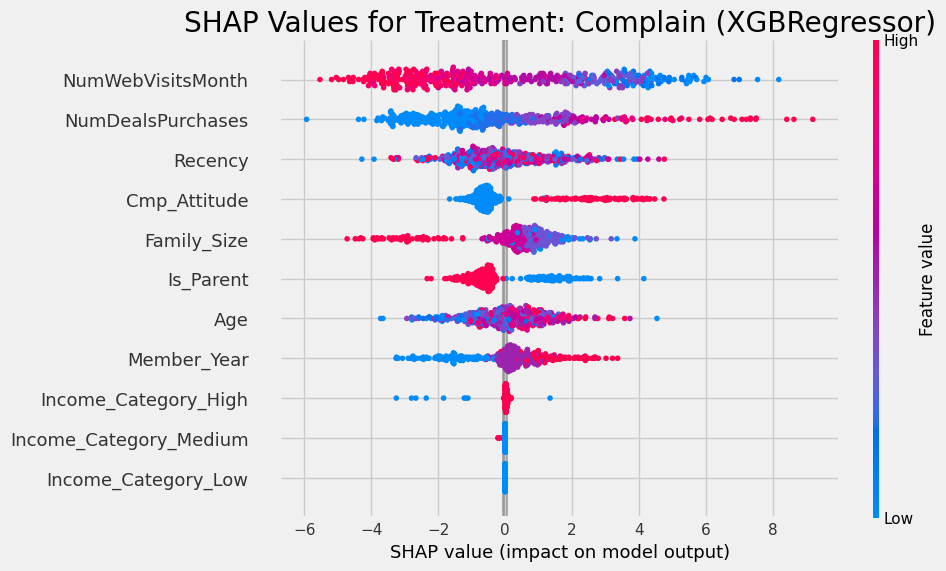

              Treatment     Model Type       ATE       RMSE
0  Income_Category_High   XGBRegressor  0.984334  13.986251
1          Cmp_Attitude  XGBTRegressor  3.572356  14.270610
2             Is_Parent   XGBRegressor  0.714974  14.285645
3              Complain   XGBRegressor  0.010959  14.830237


In [51]:
treatments = ['Income_Category_High', 'Is_Parent', 'Cmp_Attitude', 'Complain']
covariates_list = ['Income_Category_High', 'Income_Category_Low', 'Income_Category_Medium',
    'Complain', 'Is_Parent', 'Cmp_Attitude', 'Family_Size', 'Age',
    'Member_Year', 'Total_amount', 'Total_purchase',
    'NumWebVisitsMonth', 'NumDealsPurchases', 'Recency']
outcome = 'Total_purchase'

results_df = causal_inference_pipeline(df, covariates_list, treatments, outcome)
print(results_df)

# Causal 3: Monetary Value Impact

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
[17:30:34] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


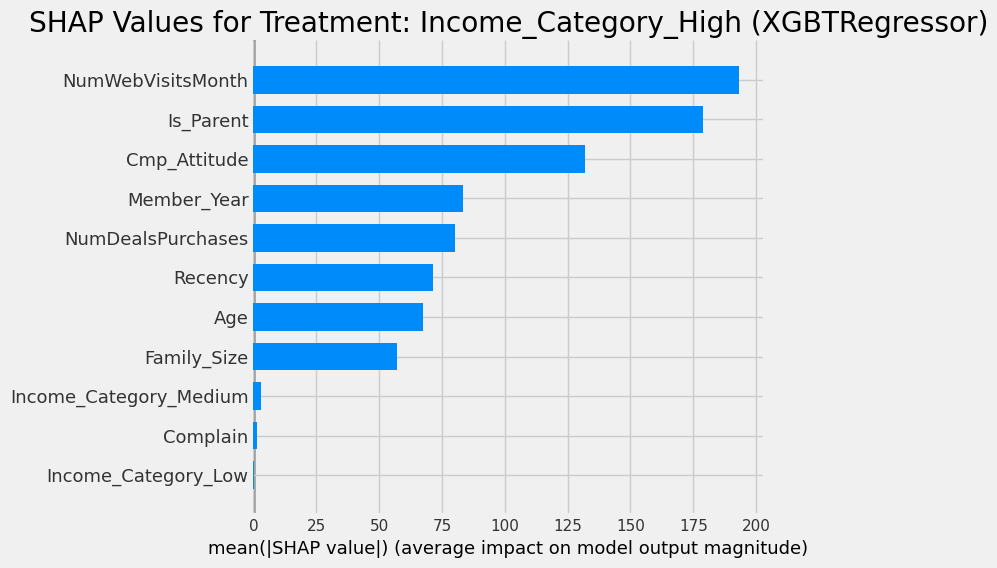

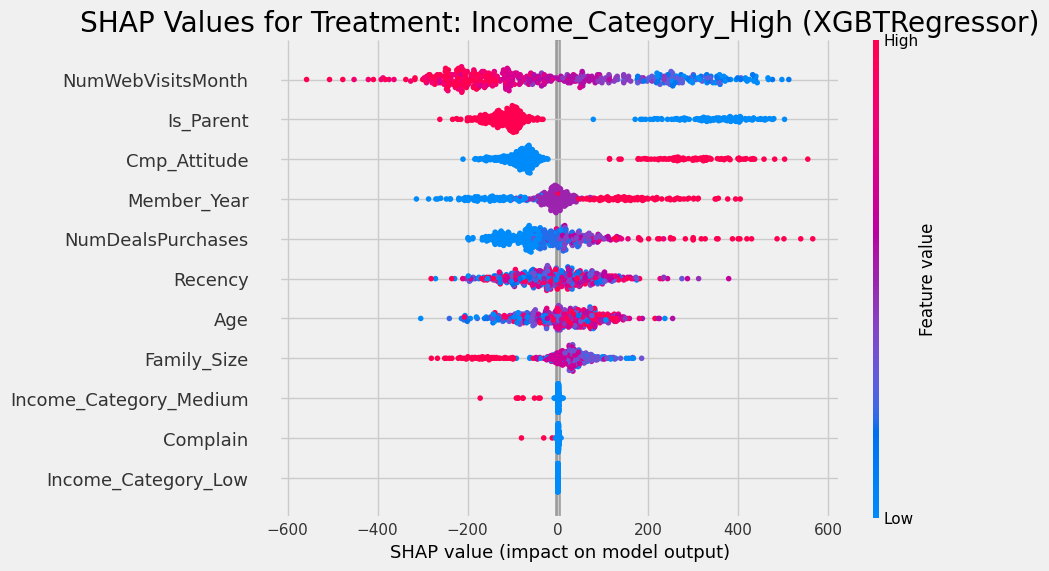

[17:30:36] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


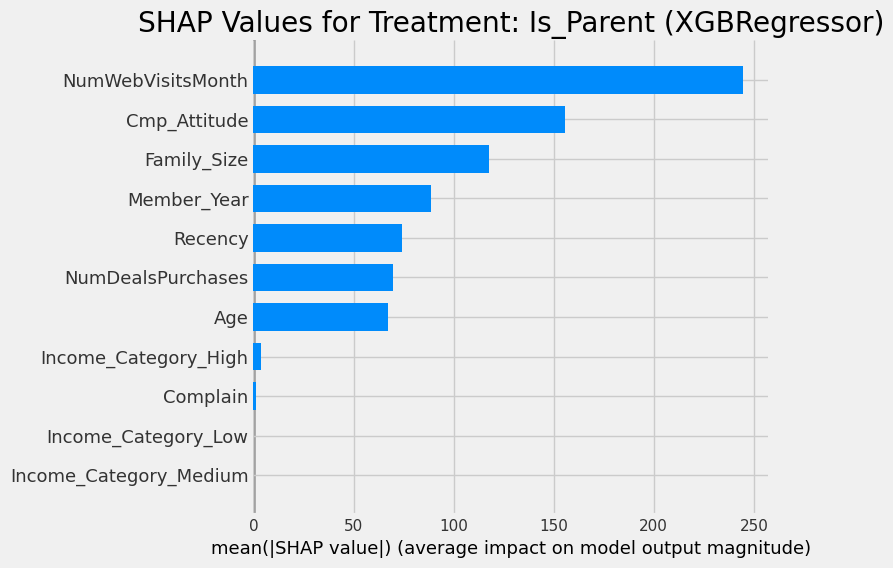

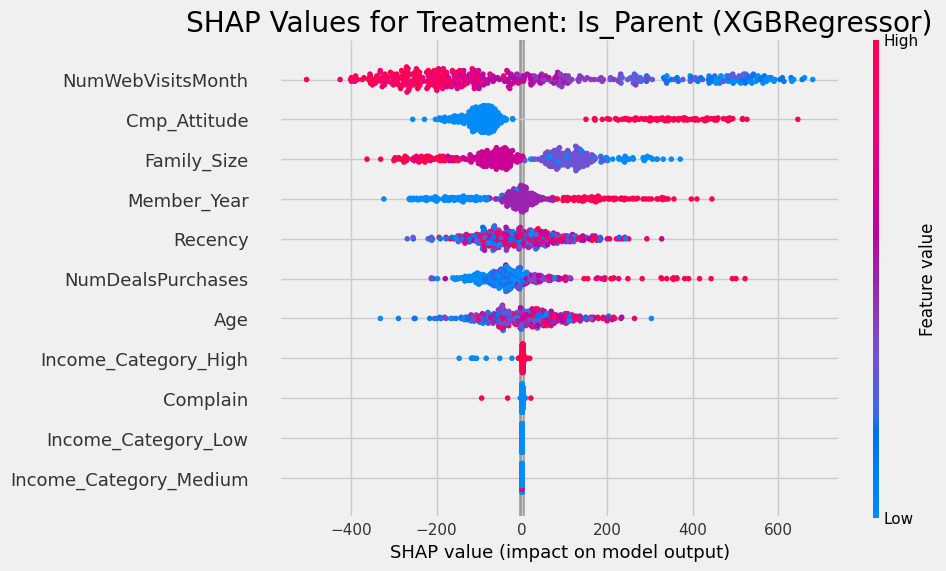

[17:30:39] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


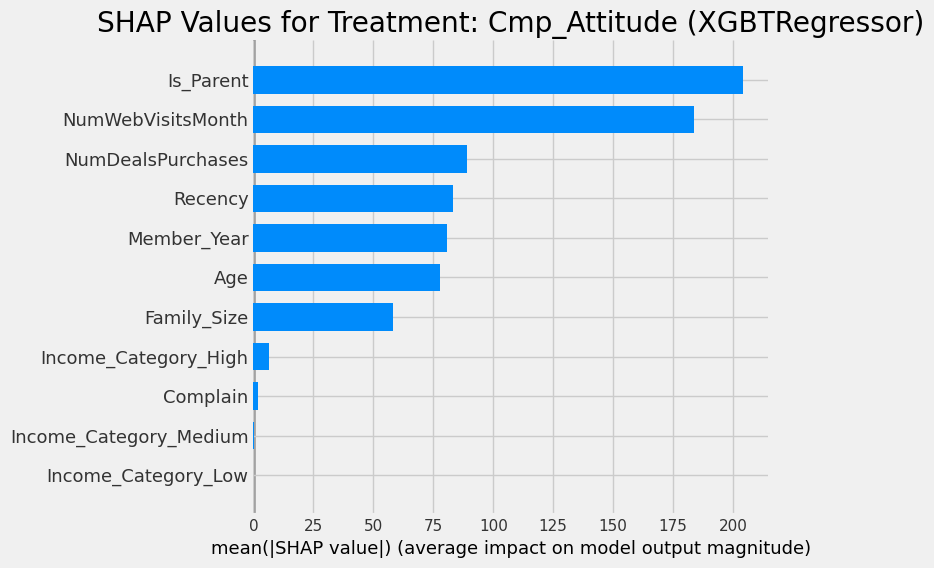

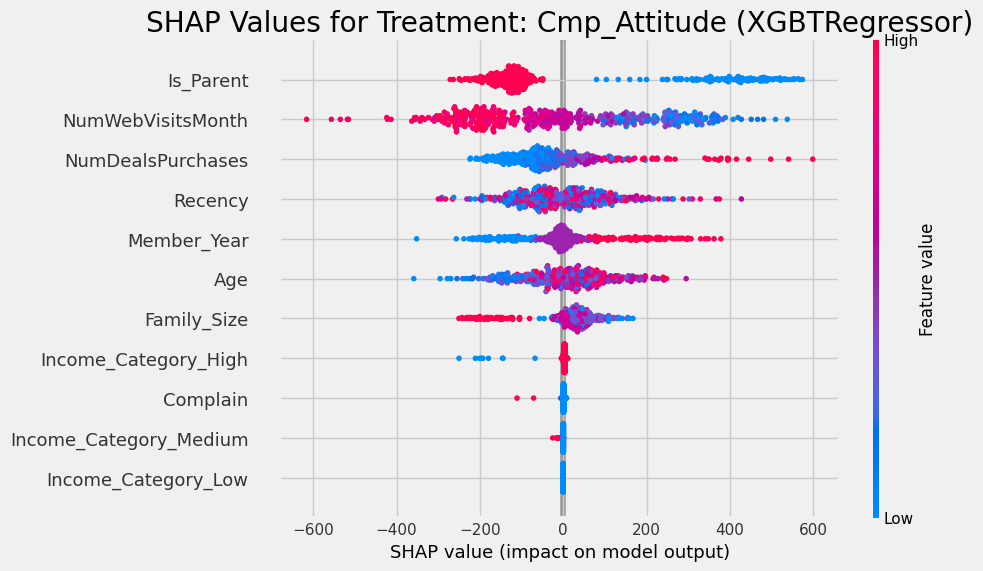

[17:30:42] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Pass `sample_weight` as keyword args.


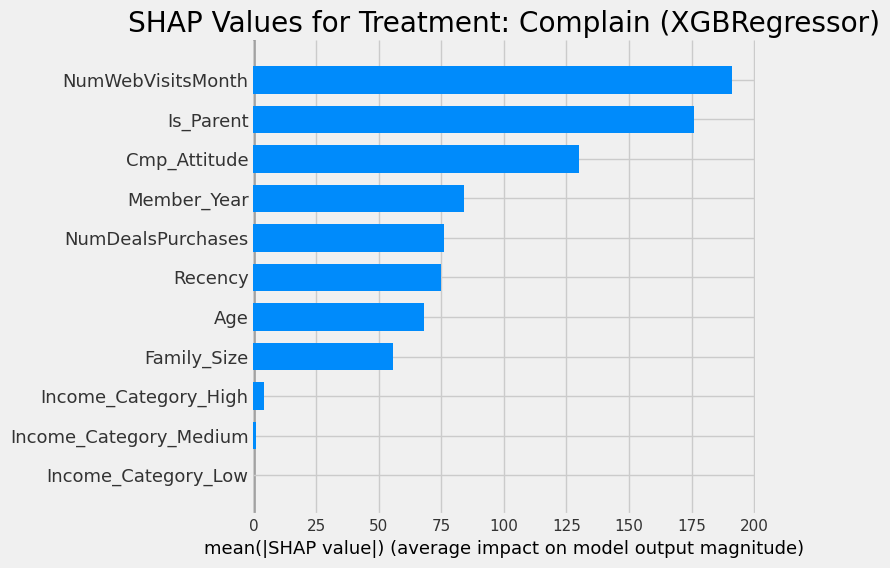

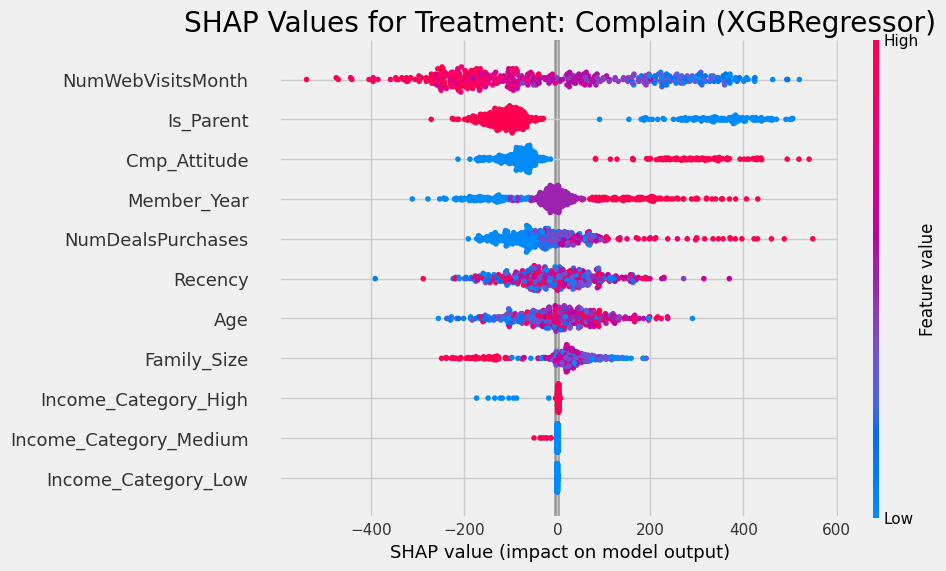

              Treatment     Model Type         ATE        RMSE
0  Income_Category_High  XGBTRegressor  346.352068  248.611976
1          Cmp_Attitude  XGBTRegressor  389.563552  828.179775
2             Is_Parent   XGBRegressor    0.715721  857.820259
3              Complain   XGBRegressor    0.013449  858.196545


In [52]:
treatments = ['Income_Category_High', 'Is_Parent', 'Cmp_Attitude', 'Complain']
covariates_list = ['Income_Category_High', 'Income_Category_Low', 'Income_Category_Medium',
    'Complain', 'Is_Parent', 'Cmp_Attitude', 'Family_Size', 'Age',
    'Member_Year', 'Total_amount', 'Total_purchase',
    'NumWebVisitsMonth', 'NumDealsPurchases', 'Recency']
outcome = 'Total_amount'

results_df = causal_inference_pipeline(df, covariates_list, treatments, outcome)
print(results_df)